In [3]:
# Standard python libraries
import os
import time
import datetime
import requests
import logging
from typing import Tuple

# Installed libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as SparkTypes, Window


from lightautoml.spark.automl.presets.tabular_presets import SparkTabularAutoML
from lightautoml.spark.dataset.base import SparkDataFrame, SparkDataset
from lightautoml.spark.tasks.base import SparkTask

In [4]:
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.ERROR)

In [5]:
def prepare_test_and_train(spark: SparkSession, path:str, seed: int) -> Tuple[SparkDataFrame, SparkDataFrame]:
    data = spark.read.csv(path, header=True, escape="\"")

    data = data.select(
        '*',
        F.monotonically_increasing_id().alias(SparkDataset.ID_COLUMN),
        F.rand(seed).alias('is_test')
    ).cache()
    data.write.mode('overwrite').format('noop').save()

    train_data = data.where(F.col('is_test') < 0.8).drop('is_test').cache()
    test_data = data.where(F.col('is_test') >= 0.8).drop('is_test').cache()

    train_data.write.mode('overwrite').format('noop').save()
    test_data.write.mode('overwrite').format('noop').save()

    return train_data, test_data

In [6]:
def get_spark_session():
    if os.environ.get("SCRIPT_ENV", None) == "cluster":
        return SparkSession.builder.getOrCreate()

    spark_sess = (
        SparkSession
        .builder
        .master("local[*]")
        .config("spark.jars", "../../jars/spark-lightautoml_2.12-0.1.jar")
        .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5")
        .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")
        .config("spark.sql.shuffle.partitions", "16")
        .config("spark.driver.memory", "12g")
        .config("spark.executor.memory", "12g")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .getOrCreate()
    )

    return spark_sess

# Create spark session

In [7]:
spark = get_spark_session()
spark.sparkContext.setLogLevel("ERROR")

22/03/21 13:25:44 WARN Utils: Your hostname, desktop resolves to a loopback address: 127.0.1.1; using 192.168.0.104 instead (on interface wlp7s0)
22/03/21 13:25:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/azamat/.ivy2/cache
The jars for the packages stored in: /home/azamat/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e398aab2-f090-4201-aa10-8f11684d4197;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/azamat/projects/LightAutoML/.venv/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.microsoft.azure#synapseml_2.12;0.9.5 in central
	found com.microsoft.azure#synapseml-core_2.12;0.9.5 in central
	found org.scalactic#scalactic_2.12;3.0.5 in central
	found org.scala-lang#scala-reflect;2.12.4 in central
	found io.spray#spray-json_2.12;1.3.2 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents#httpclient;4.5.6 in central
	found org.apache.httpcomponents#httpcore;4.4.10 in central
	found commons-logging#commons-logging;1.2 in central
	found commons-codec#commons-codec;1.10 in central
	found org.apache.httpcomponents#httpmime;4.5.6 in central
	found com.linkedin.isolation-forest#isolation-forest_3.2.0_2.12;2.0.8 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found org.typelevel#macro-compat_2.12;1.1.1 in central
	found org.apache.spark#spark-avro_2.12;3.2.0 in central
	found org.tukaani#xz;1.8 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.testng#testng;6.8.8 in central
	found org.bean

22/03/21 13:25:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/21 13:25:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [8]:
seed = 42
cv = 2
use_algos = [["lgb"]]
path = "/opt/spark_data/small_used_cars_data_cleaned.csv"
task_type = "reg"
roles = {
    "target": "price",
    "drop": ["dealer_zip", "description", "listed_date",
             "year", 'Unnamed: 0', '_c0',
             'sp_id', 'sp_name', 'trimId',
             'trim_name', 'major_options', 'main_picture_url',
             'interior_color', 'exterior_color'],
    "numeric": ['latitude', 'longitude', 'mileage']
}

In [9]:
train_data, test_data = prepare_test_and_train(spark, path, seed)

# Create AutoML from preset

In [10]:
task = SparkTask(task_type)

automl = SparkTabularAutoML(
    spark=spark,
    task=task,
    lgb_params={'use_single_dataset_mode': True},
    linear_l2_params={"default_params": {"regParam": [1]}},
    general_params={"use_algos": use_algos},
    reader_params={"cv": cv, "advanced_roles": False, 'random_state': seed},
    tuning_params={'fit_on_holdout': True, 'max_tuning_iter': 50, 'max_tuning_time': 3600}
)

oof_pred = automl.fit_predict(
    train_data,
    roles=roles
)

features pipeline ctr
lama advanced pipeline ctr
features pipeline ctr
i am here


[LightGBM] [Warning] Only find one worker, will switch to serial tree learner
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0,085696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 4018, number of used features: 48
[LightGBM] [Info] Start training from score 27566,985565


[LightGBM] [Warning] Only find one worker, will switch to serial tree learner
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,006520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4549
[LightGBM] [Info] Number of data points in the train set: 4018, number of used features: 51
[LightGBM] [Info] Start training from score 27566,985565


[LightGBM] [Warning] Only find one worker, will switch to serial tree learner
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,004685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4558
[LightGBM] [Info] Number of data points in the train set: 4057, number of used features: 51
[LightGBM] [Info] Start training from score 27402,260291


In [11]:
automl.reader._roles

{'latitude': Numeric role, dtype <class 'numpy.float32'>. Additional params: [('force_input', False), ('prob', False), ('discretization', False)],
 'longitude': Numeric role, dtype <class 'numpy.float32'>. Additional params: [('force_input', False), ('prob', False), ('discretization', False)],
 'mileage': Numeric role, dtype <class 'numpy.float32'>. Additional params: [('force_input', False), ('prob', False), ('discretization', False)],
 'vin': Category role, dtype <class 'object'>. Additional params: [('encoding_type', 'auto'), ('unknown', 5), ('force_input', False), ('label_encoded', False), ('ordinal', False)],
 'back_legroom': Numeric role, dtype <class 'numpy.float32'>. Additional params: [('force_input', False), ('prob', False), ('discretization', False)],
 'bed': Category role, dtype <class 'object'>. Additional params: [('encoding_type', 'auto'), ('unknown', 5), ('force_input', False), ('label_encoded', False), ('ordinal', False)],
 'bed_length': Numeric role, dtype <class 'num

### Calculate data for PDP plot manually:

In [12]:
%%time

grid, ys, counts = automl.get_individual_pdp(test_data, feature_name='latitude', n_bins=30, preds_fraction=0.2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:50<00:00,  3.69s/it]

CPU times: user 12.7 s, sys: 4.15 s, total: 16.8 s
Wall time: 1min 51s


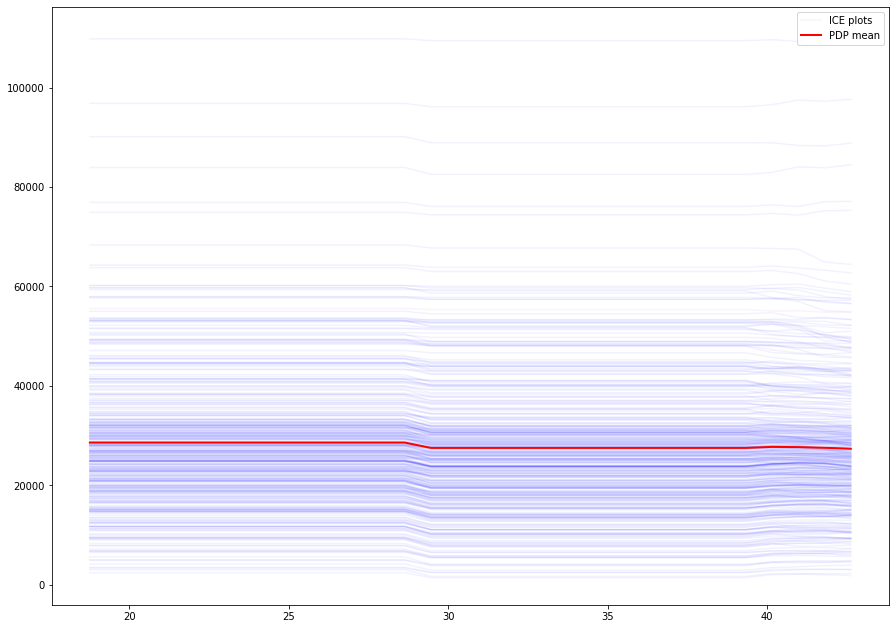

CPU times: user 2.99 s, sys: 1.46 s, total: 4.46 s
Wall time: 1.59 s


In [13]:
%%time

X = np.array([item.ravel() for item in ys]).T

plt.figure(figsize=(15, 11))
plt.plot(grid, X[0], alpha=0.05, color='m', label='ICE plots')
for i in range(1, X.shape[0]):
    plt.plot(grid, X[i], alpha=0.05, color='b')
plt.plot(grid, X.mean(axis=0), linewidth=2, color='r', label='PDP mean')
plt.legend()
plt.show()

### Built-in function:

### Numeric features

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:44<00:00,  3.48s/it]


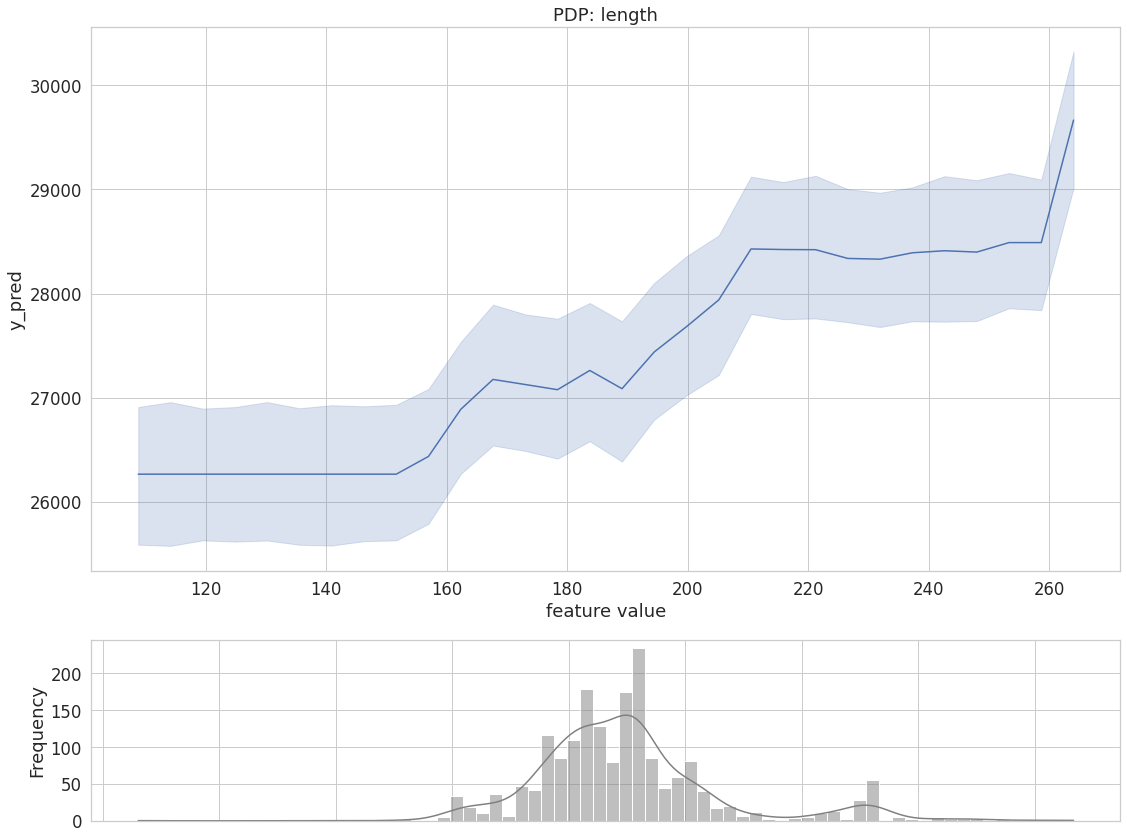

In [14]:
automl.plot_pdp(test_data, feature_name='length', n_bins=30)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:42<00:00,  3.40s/it]


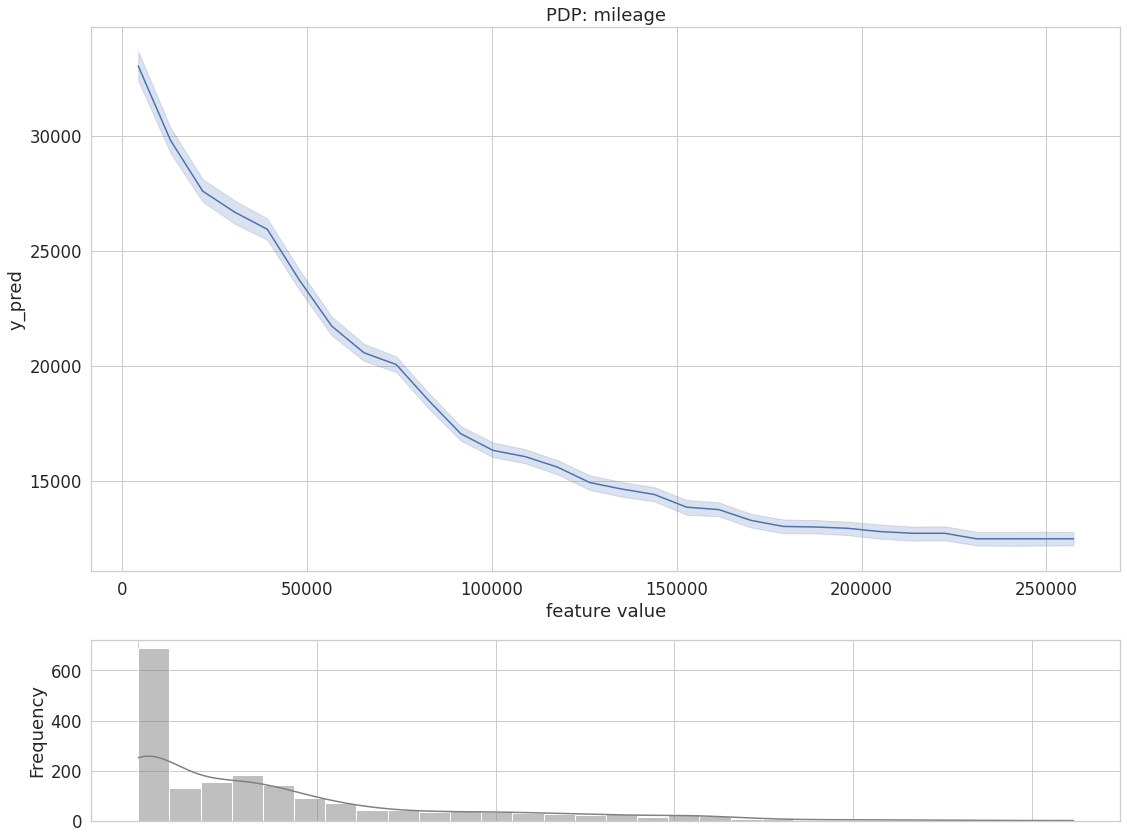

In [15]:
automl.plot_pdp(test_data, feature_name='mileage', n_bins=30)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.35s/it]


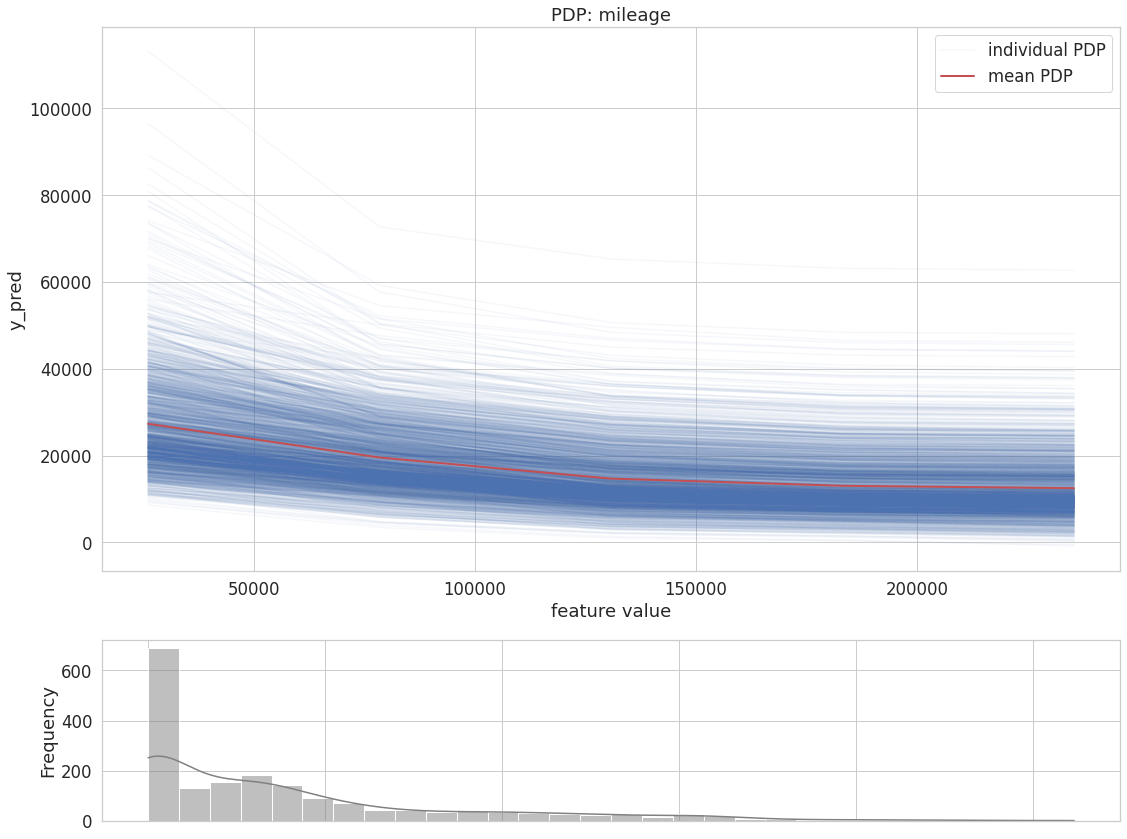

In [16]:
automl.plot_pdp(test_data, feature_name='mileage', individual=True, n_bins=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:43<00:00,  3.45s/it]


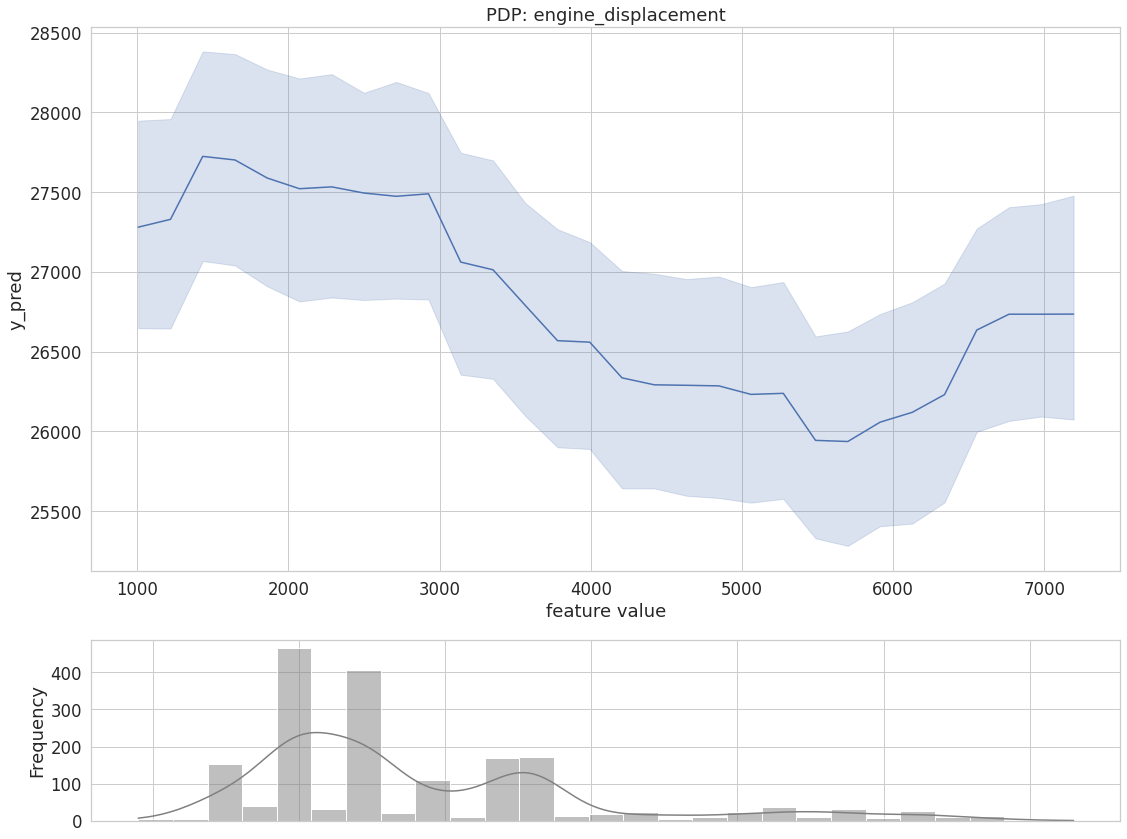

CPU times: user 15 s, sys: 4.36 s, total: 19.4 s
Wall time: 1min 45s


In [17]:
%%time

automl.plot_pdp(test_data, feature_name='engine_displacement')

### Category features

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.47s/it]


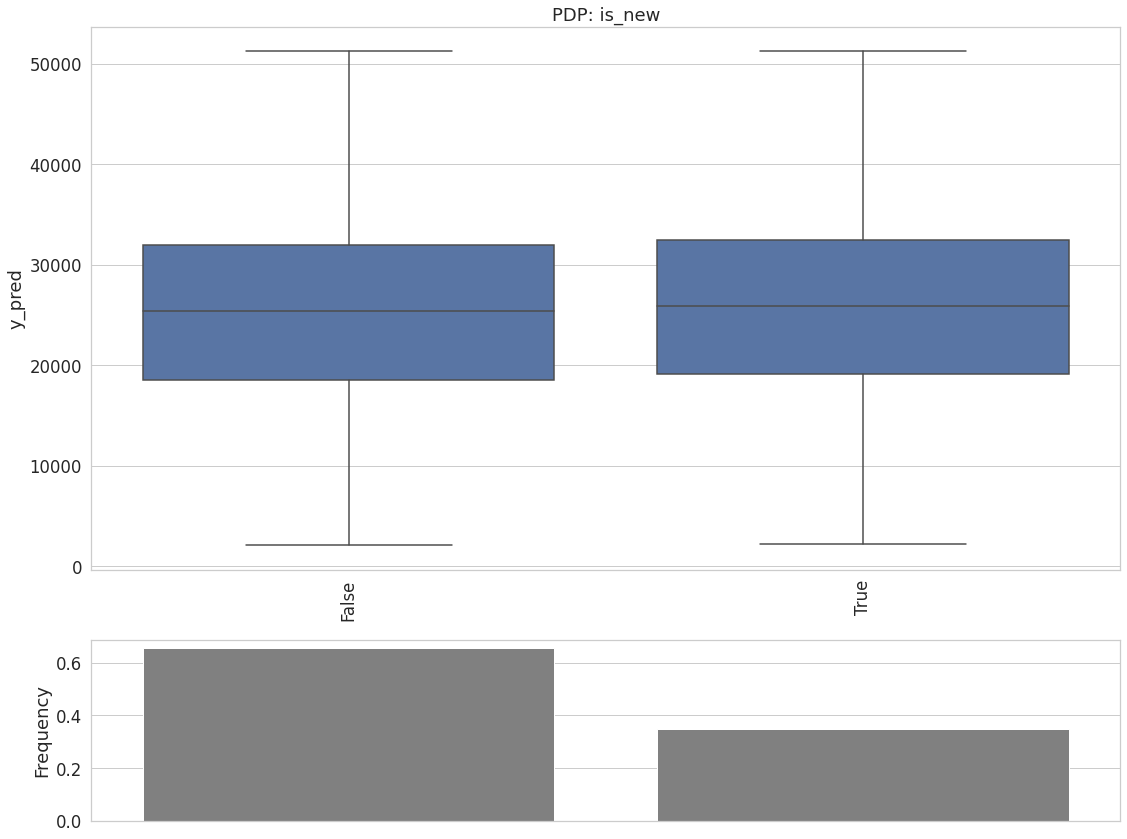

CPU times: user 1.29 s, sys: 366 ms, total: 1.66 s
Wall time: 7.57 s


In [18]:
%%time

automl.plot_pdp(test_data, feature_name='is_new', preds_fraction=0.2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.34s/it]


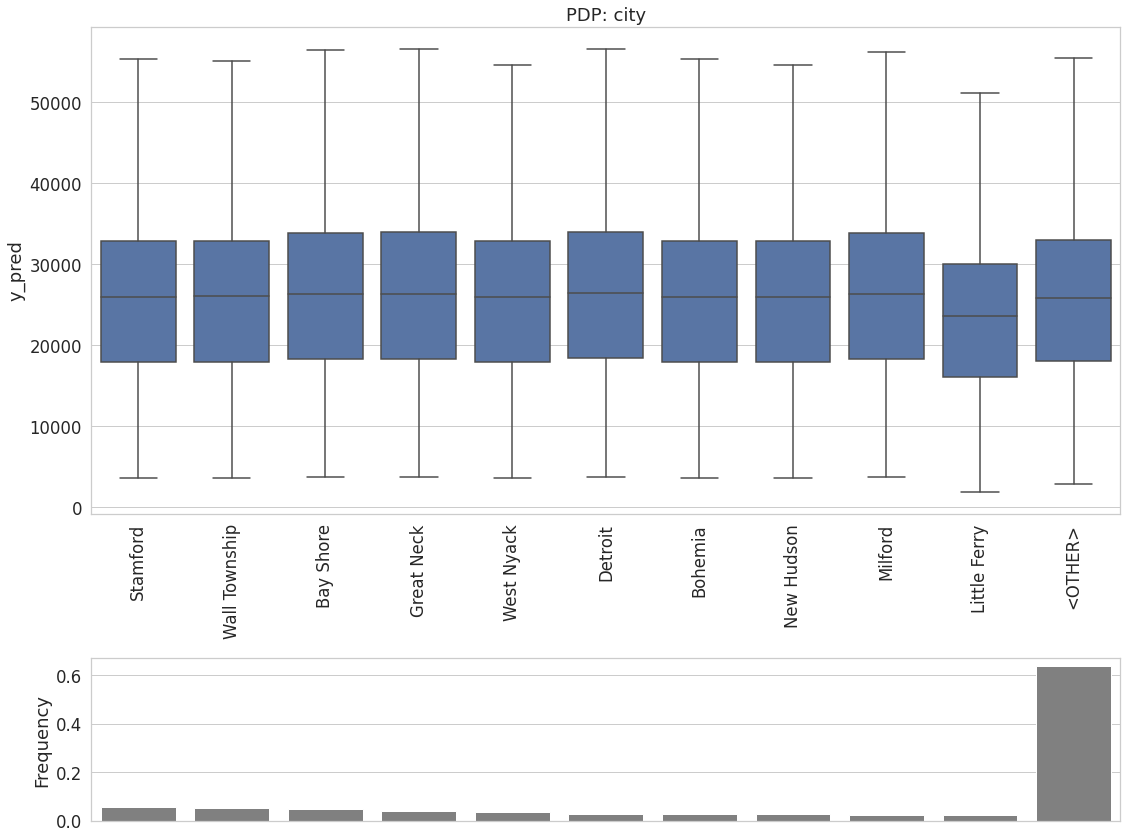

CPU times: user 5.06 s, sys: 1.62 s, total: 6.68 s
Wall time: 38.6 s


In [14]:
%%time

automl.plot_pdp(test_data, feature_name='city')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.49s/it]


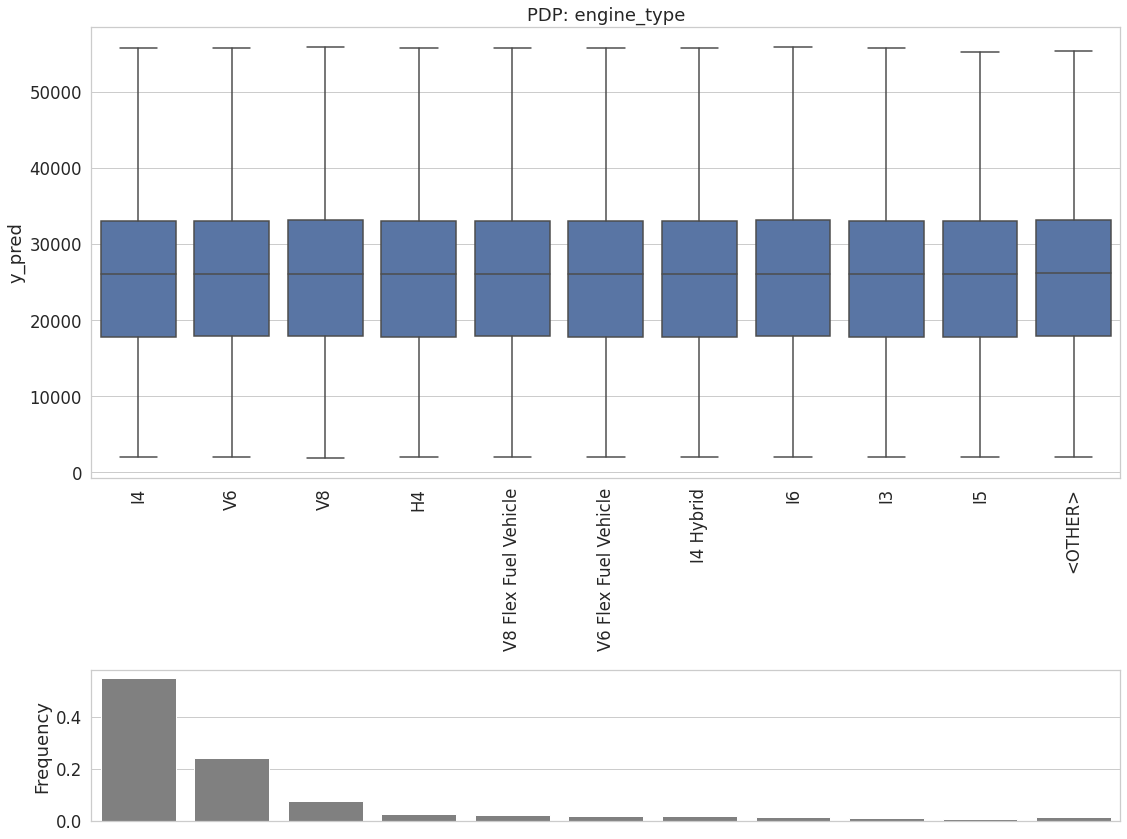

CPU times: user 6.65 s, sys: 3.27 s, total: 9.92 s
Wall time: 40.2 s


In [9]:
%%time

automl.plot_pdp(test_data, feature_name='engine_type')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.27s/it]


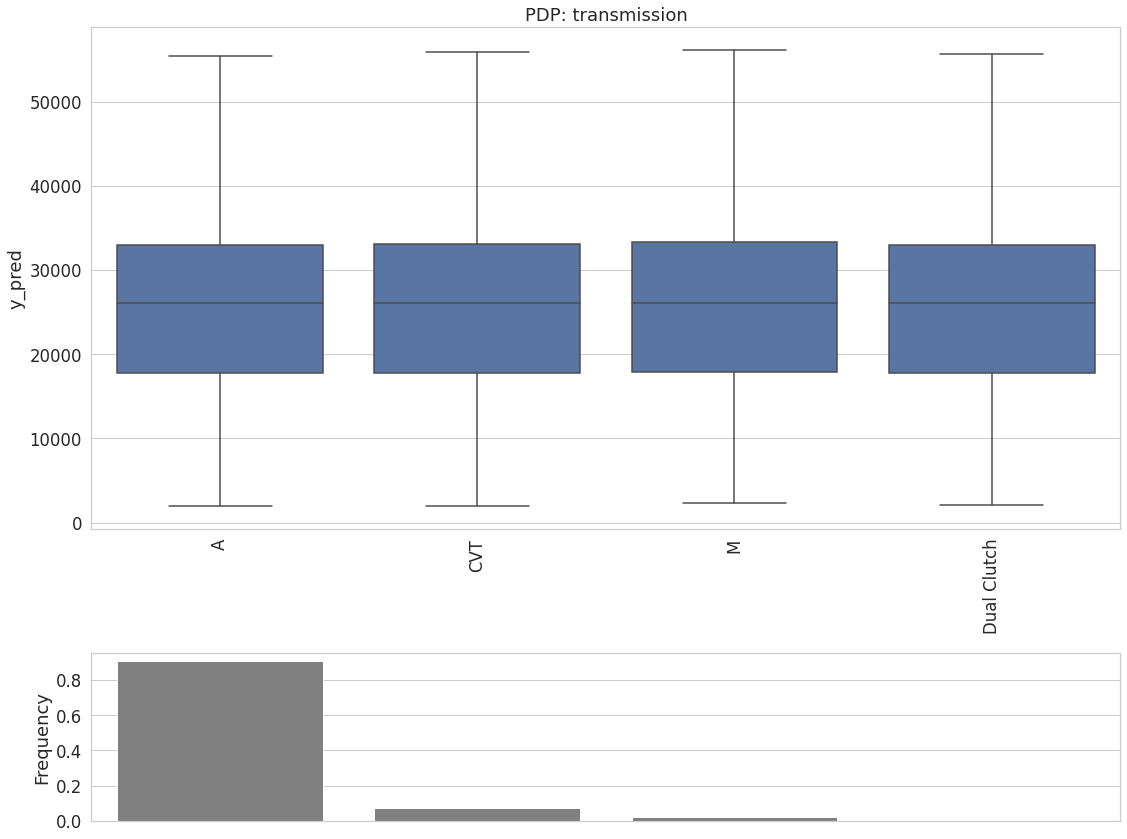

In [12]:
automl.plot_pdp(test_data, feature_name='transmission')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.39s/it]


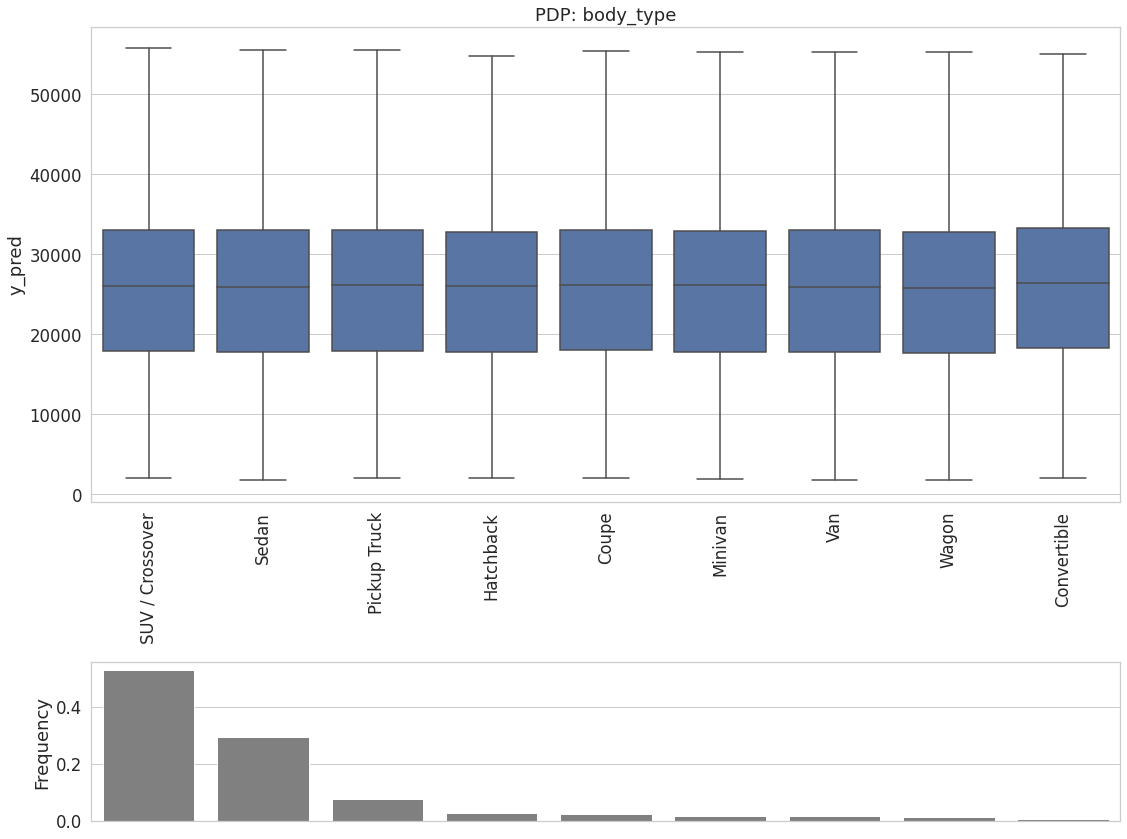

In [11]:
automl.plot_pdp(test_data, feature_name='body_type')

### get_feature_scores

In [21]:
automl.get_feature_scores(data=test_data)

,Feature,Importance
0,horsepower,1.817077e+13
1,mileage,1.539255e+13
2,model_name,2.118936e+12
3,owner_count,2.039793e+12
4,franchise_make,1.793791e+12
5,width,1.183225e+12
6,fuel_tank_volume,9.945215e+11
7,wheel_system,8.729124e+11
8,make_name,7.319442e+11
9,front_legroom,7.106736e+11


In [22]:
automl.get_feature_scores(calc_method="accurate", data=test_data, silent=False)

,Feature,Importance
0,mileage,1.046249e+08
1,horsepower,6.032323e+07
2,model_name,4.183428e+07
3,make_name,7.375310e+06
4,city,3.913050e+06
5,power,2.875110e+06
6,height,2.101067e+06
7,owner_count,2.055999e+06
8,wheel_system,1.804544e+06
9,torque,1.802957e+06
